# Librerias

In [252]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import display, HTML

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Configuracion General

In [2]:
%matplotlib inline
plt.style.use('ggplot')

plt.rcParams["figure.figsize"] = (18,6)
sns.set_palette("husl")

ESTILO = "background-color:lightgrey; display:inline"
pd.options.mode.chained_assignment = None

TARGET = 'readmitted'
SEED = 42

In [3]:
def dropear_columnas(dataset, columnas):
    return dataset.drop(columnas, axis = 1)

In [4]:
df_raw = pd.read_csv("data\diabetic_data.csv")

# Vista del Dataset: Head/Tail

In [5]:
display(df_raw.head())
display(HTML('<br><hr><br>'))
display(df_raw.tail())

,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
0,2278392,8222157,Caucasian,Female,[0-10),?,6,25,1,1,...,No,No,No,No,No,No,No,No,No,NO
1,149190,55629189,Caucasian,Female,[10-20),?,1,1,7,3,...,No,Up,No,No,No,No,No,Ch,Yes,>30
2,64410,86047875,AfricanAmerican,Female,[20-30),?,1,1,7,2,...,No,No,No,No,No,No,No,No,Yes,NO
3,500364,82442376,Caucasian,Male,[30-40),?,1,1,7,2,...,No,Up,No,No,No,No,No,Ch,Yes,NO
4,16680,42519267,Caucasian,Male,[40-50),?,1,1,7,1,...,No,Steady,No,No,No,No,No,Ch,Yes,NO


,encounter_id,patient_nbr,race,gender,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
101761,443847548,100162476,AfricanAmerican,Male,[70-80),?,1,3,7,3,...,No,Down,No,No,No,No,No,Ch,Yes,>30
101762,443847782,74694222,AfricanAmerican,Female,[80-90),?,1,4,5,5,...,No,Steady,No,No,No,No,No,No,Yes,NO
101763,443854148,41088789,Caucasian,Male,[70-80),?,1,1,7,1,...,No,Down,No,No,No,No,No,Ch,Yes,NO
101764,443857166,31693671,Caucasian,Female,[80-90),?,2,3,7,10,...,No,Up,No,No,No,No,No,Ch,Yes,NO
101765,443867222,175429310,Caucasian,Male,[70-80),?,1,1,7,6,...,No,No,No,No,No,No,No,No,No,NO


In [6]:
df_raw = dropear_columnas(df_raw, ['encounter_id', 'patient_nbr'])

# Información sobre el Dataset

In [7]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 48 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   race                      101766 non-null  object
 1   gender                    101766 non-null  object
 2   age                       101766 non-null  object
 3   weight                    101766 non-null  object
 4   admission_type_id         101766 non-null  int64 
 5   discharge_disposition_id  101766 non-null  int64 
 6   admission_source_id       101766 non-null  int64 
 7   time_in_hospital          101766 non-null  int64 
 8   payer_code                101766 non-null  object
 9   medical_specialty         101766 non-null  object
 10  num_lab_procedures        101766 non-null  int64 
 11  num_procedures            101766 non-null  int64 
 12  num_medications           101766 non-null  int64 
 13  number_outpatient         101766 non-null  int64 
 14  numb

In [8]:
df_raw.drop_duplicates(inplace=True)

# Descripción del Dataset

In [9]:
display(df_raw.describe().T)
display(df_raw.describe(include=[object]))

,count,mean,std,min,25%,50%,75%,max
admission_type_id,101766.0,2.024006,1.445403,1.0,1.0,1.0,3.0,8.0
discharge_disposition_id,101766.0,3.715642,5.280166,1.0,1.0,1.0,4.0,28.0
admission_source_id,101766.0,5.754437,4.064081,1.0,1.0,7.0,7.0,25.0
time_in_hospital,101766.0,4.395987,2.985108,1.0,2.0,4.0,6.0,14.0
num_lab_procedures,101766.0,43.095641,19.674362,1.0,31.0,44.0,57.0,132.0
num_procedures,101766.0,1.339730,1.705807,0.0,0.0,1.0,2.0,6.0
num_medications,101766.0,16.021844,8.127566,1.0,10.0,15.0,20.0,81.0
number_outpatient,101766.0,0.369357,1.267265,0.0,0.0,0.0,0.0,42.0
number_emergency,101766.0,0.197836,0.930472,0.0,0.0,0.0,0.0,76.0
number_inpatient,101766.0,0.635566,1.262863,0.0,0.0,0.0,1.0,21.0


,race,gender,age,weight,payer_code,medical_specialty,diag_1,diag_2,diag_3,max_glu_serum,...,citoglipton,insulin,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted
count,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766,...,101766,101766,101766,101766,101766,101766,101766,101766,101766,101766
unique,6,3,10,10,18,73,717,749,790,4,...,1,4,4,2,2,2,2,2,2,3
top,Caucasian,Female,[70-80),?,?,?,428,276,250,None,...,No,No,No,No,No,No,No,No,Yes,NO
freq,76099,54708,26068,98569,40256,49949,6862,6752,11555,96420,...,101766,47383,101060,101753,101765,101764,101765,54755,78363,54864


# Comprobación de Nulos

In [10]:
df_raw.isnull().sum()

race                        0
gender                      0
age                         0
weight                      0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
medical_specialty           0
num_lab_procedures          0
num_procedures              0
num_medications             0
number_outpatient           0
number_emergency            0
number_inpatient            0
diag_1                      0
diag_2                      0
diag_3                      0
number_diagnoses            0
max_glu_serum               0
A1Cresult                   0
metformin                   0
repaglinide                 0
nateglinide                 0
chlorpropamide              0
glimepiride                 0
acetohexamide               0
glipizide                   0
glyburide                   0
tolbutamide                 0
pioglitazone                0
rosiglitazone               0
acarbose  

# EDA Univariable

In [11]:
columnas_cat      = []
columnas_cat_diag = []
columnas_dropear  = []
columnas_num      = []

## Race

In [12]:
display(df_raw['race'].value_counts(normalize=True))

Caucasian          0.747784
AfricanAmerican    0.188766
?                  0.022336
Hispanic           0.020017
Other              0.014799
Asian              0.006299
Name: race, dtype: float64

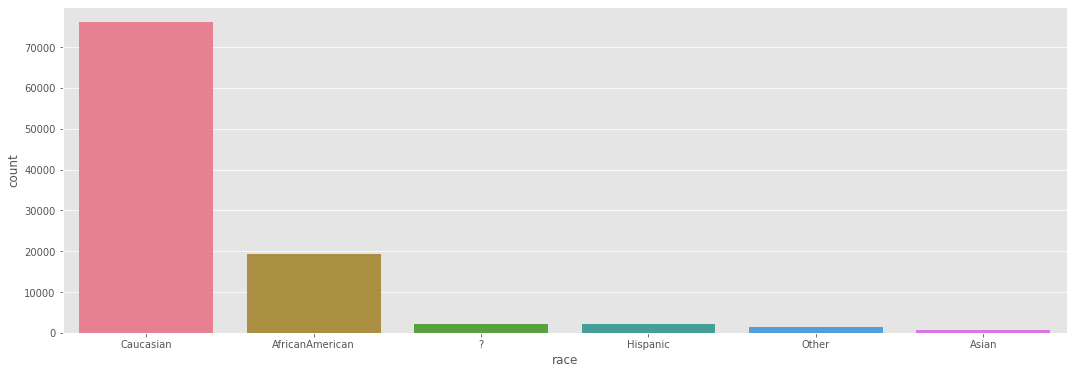

In [13]:
sns.countplot(x=df_raw['race'], 
              order = df_raw['race'].value_counts().index);

In [14]:
columnas_cat.append('race')

## Gender

In [15]:
display(df_raw['gender'].value_counts())

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [16]:
columnas_cat.append('gender')

## Age

In [17]:
display(df_raw['age'].value_counts(normalize=True))

[70-80)     0.256156
[60-70)     0.220928
[50-60)     0.169565
[80-90)     0.168986
[40-50)     0.095169
[30-40)     0.037095
[90-100)    0.027445
[20-30)     0.016282
[10-20)     0.006790
[0-10)      0.001582
Name: age, dtype: float64

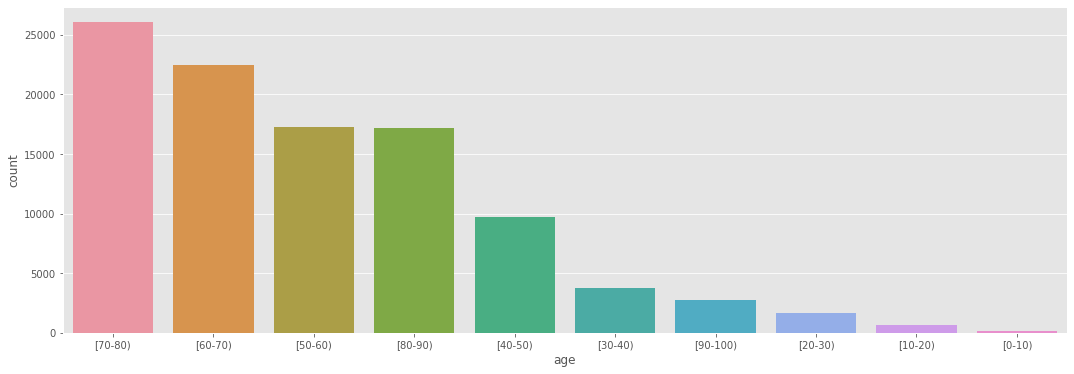

In [18]:
sns.countplot(x=df_raw['age'], 
              order = df_raw['age'].value_counts().index);

In [19]:
columnas_cat.append('age')

## Weight

In [20]:
display(df_raw['weight'].value_counts(normalize=True))

?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: weight, dtype: float64

In [21]:
columnas_dropear.append('weight')

## Admission type id

In [22]:
display(df_raw['admission_type_id'].value_counts(normalize=True))

1    0.530531
3    0.185416
2    0.181593
6    0.051992
5    0.047020
8    0.003144
7    0.000206
4    0.000098
Name: admission_type_id, dtype: float64

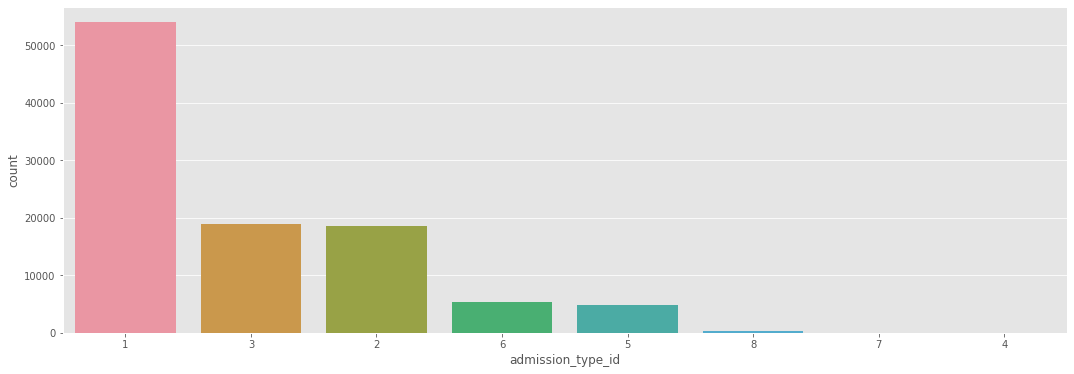

In [23]:
sns.countplot(x=df_raw['admission_type_id'], 
              order = df_raw['admission_type_id'].value_counts().index);

In [24]:
columnas_cat.append('admission_type_id')

## Discharge disposition id

In [25]:
display(df_raw['discharge_disposition_id'].value_counts())

1     60234
3     13954
6     12902
18     3691
2      2128
22     1993
11     1642
5      1184
25      989
4       815
7       623
23      412
13      399
14      372
28      139
8       108
15       63
24       48
9        21
17       14
16       11
19        8
10        6
27        5
12        3
20        2
Name: discharge_disposition_id, dtype: int64

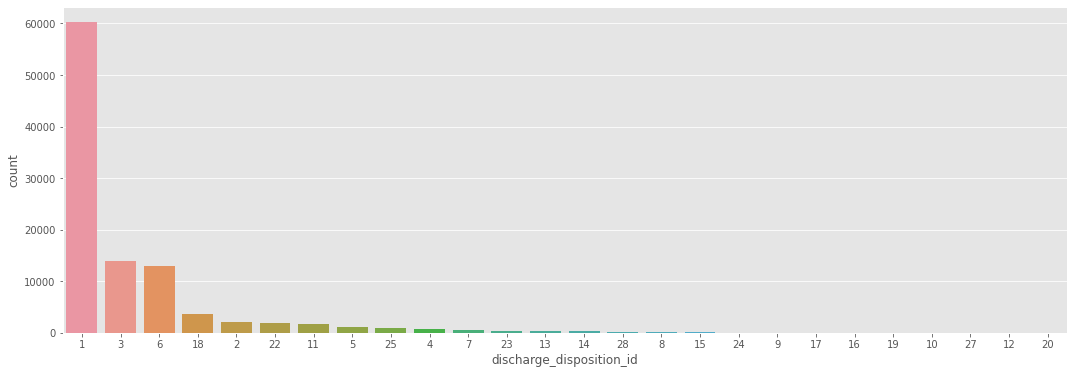

In [26]:
sns.countplot(x=df_raw['discharge_disposition_id'], 
              order = df_raw['discharge_disposition_id'].value_counts().index);

In [27]:
columnas_cat.append('discharge_disposition_id')

## Admission source id

In [28]:
display(df_raw['admission_source_id'].value_counts(normalize=True))

7     0.564963
1     0.290519
17    0.066633
4     0.031317
6     0.022247
2     0.010848
5     0.008402
3     0.001838
20    0.001582
9     0.001228
8     0.000157
22    0.000118
10    0.000079
11    0.000020
14    0.000020
25    0.000020
13    0.000010
Name: admission_source_id, dtype: float64

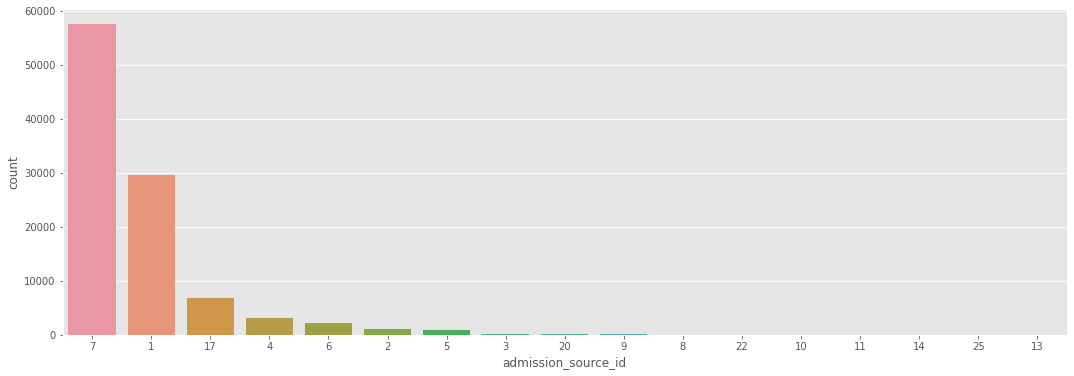

In [29]:
sns.countplot(x=df_raw['admission_source_id'], 
              order = df_raw['admission_source_id'].value_counts().index);

In [30]:
columnas_cat.append('admission_source_id')

## Time in Hospital

In [31]:
display(df_raw['time_in_hospital'].value_counts(normalize=True))

3     0.174479
2     0.169251
1     0.139614
4     0.136824
5     0.097931
6     0.074082
7     0.057573
8     0.043148
9     0.029499
10    0.023014
11    0.018228
12    0.014229
13    0.011890
14    0.010239
Name: time_in_hospital, dtype: float64

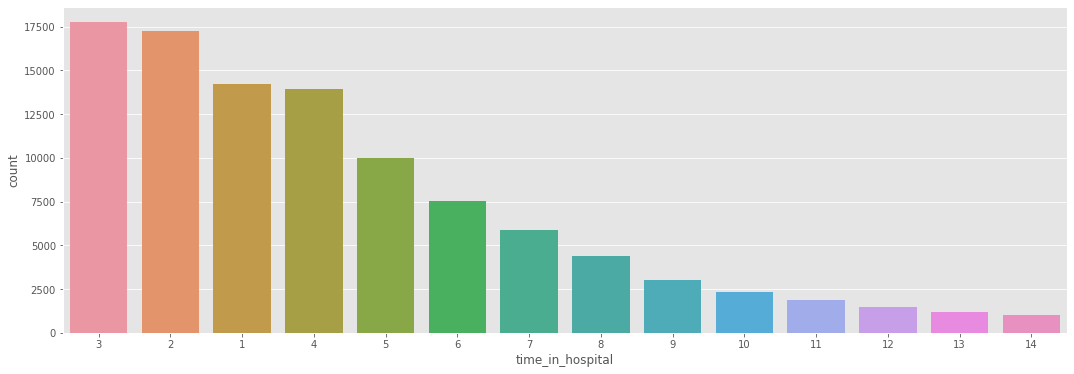

In [32]:
sns.countplot(x=df_raw['time_in_hospital'], 
              order = df_raw['time_in_hospital'].value_counts().index);

In [33]:
columnas_cat.append('time_in_hospital')

## Payer code

In [34]:
display(df_raw['payer_code'].value_counts(normalize=True))

?     0.395574
MC    0.318761
HM    0.061651
SP    0.049201
BC    0.045742
MD    0.034707
CP    0.024890
UN    0.024055
CM    0.019034
OG    0.010151
PO    0.005817
DM    0.005395
CH    0.001435
WC    0.001327
OT    0.000934
MP    0.000776
SI    0.000540
FR    0.000010
Name: payer_code, dtype: float64

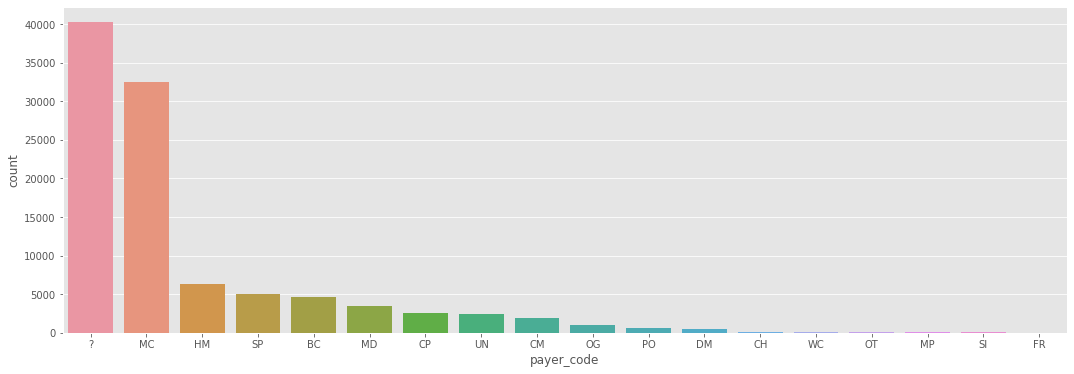

In [35]:
sns.countplot(x=df_raw['payer_code'], 
              order = df_raw['payer_code'].value_counts().index);

In [36]:
columnas_cat.append('payer_code')

## Medical Specialty         

In [37]:
display(df_raw['medical_specialty'].value_counts(normalize=True))

?                                0.490822
InternalMedicine                 0.143810
Emergency/Trauma                 0.074337
Family/GeneralPractice           0.073109
Cardiology                       0.052591
                                   ...   
Dermatology                      0.000010
Pediatrics-InfectiousDiseases    0.000010
Psychiatry-Addictive             0.000010
Speech                           0.000010
Proctology                       0.000010
Name: medical_specialty, Length: 73, dtype: float64

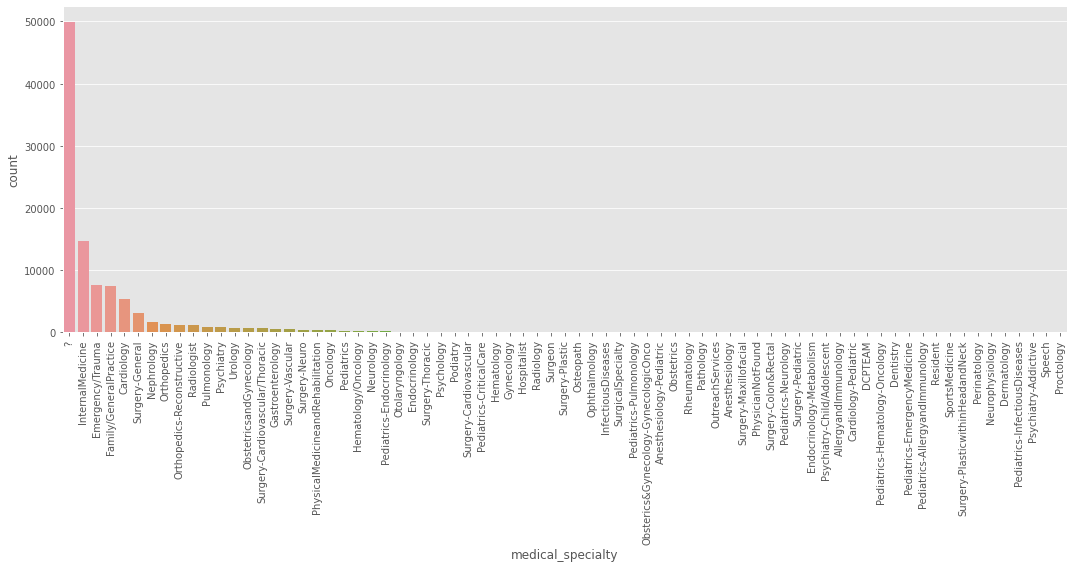

In [38]:
sns.countplot(x=df_raw['medical_specialty'], 
              order = df_raw['medical_specialty'].value_counts().index);
plt.xticks(rotation = 90);

In [39]:
columnas_dropear.append('medical_specialty')

## N° Lab Procedures 

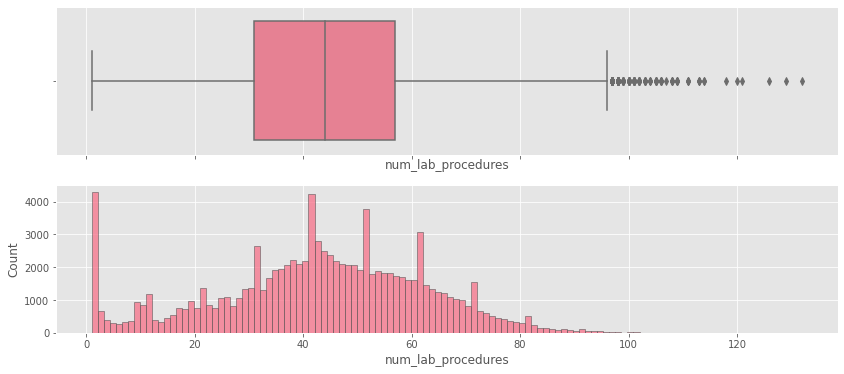

In [40]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['num_lab_procedures'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="num_lab_procedures",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

## N° Procedures

In [41]:
display(df_raw['num_procedures'].value_counts(normalize=True))

0    0.458424
1    0.203821
2    0.124963
3    0.092791
6    0.048680
4    0.041075
5    0.030246
Name: num_procedures, dtype: float64

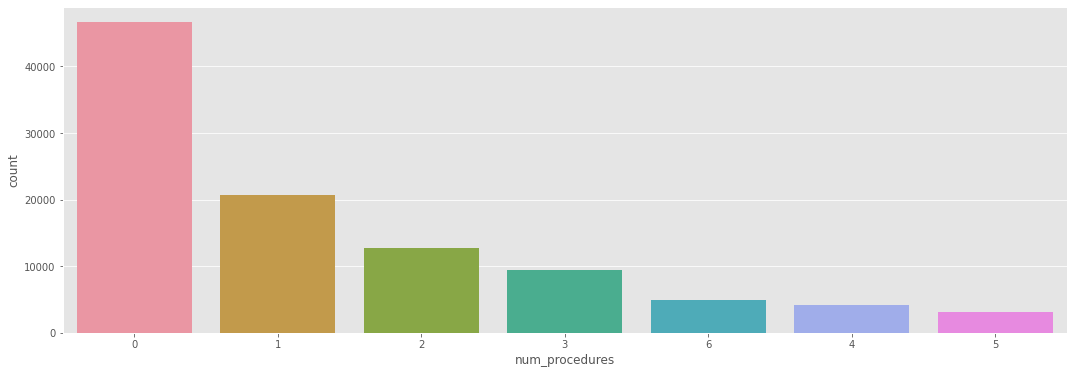

In [42]:
sns.countplot(x=df_raw['num_procedures'], 
              order = df_raw['num_procedures'].value_counts().index);

In [43]:
columnas_cat.append('num_procedures')

## N° Medications 

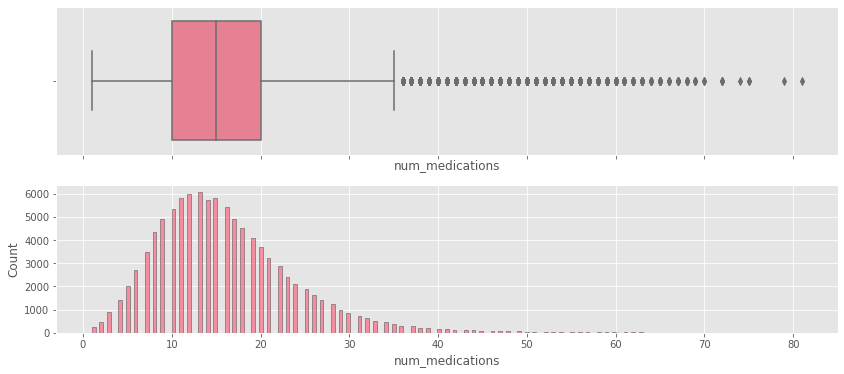

In [44]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['num_medications'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="num_medications",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [45]:
columnas_num.append("num_medications")

## N° Outpatient

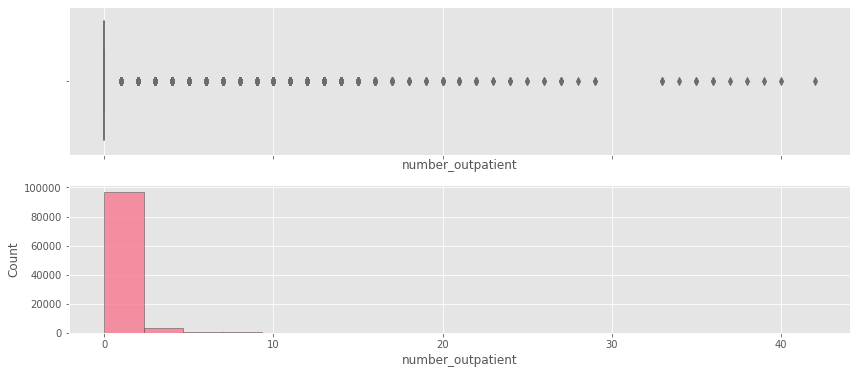

In [46]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_outpatient'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_outpatient",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [47]:
columnas_dropear.append("num_medications")

## N° emergency

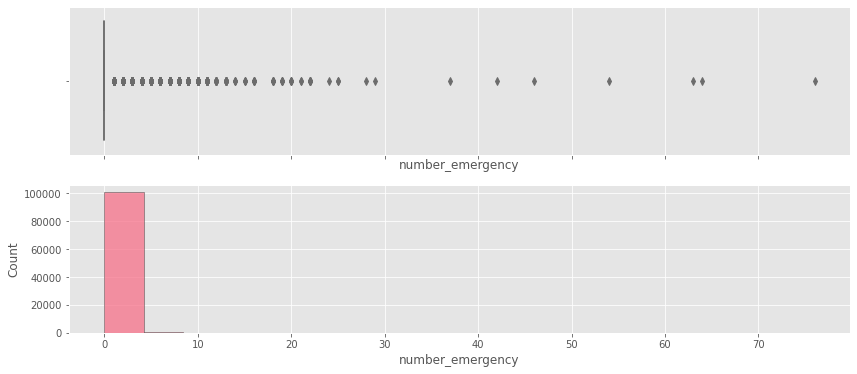

In [48]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_emergency'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_emergency",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [49]:
columnas_dropear.append("number_emergency")

## N° inpatient

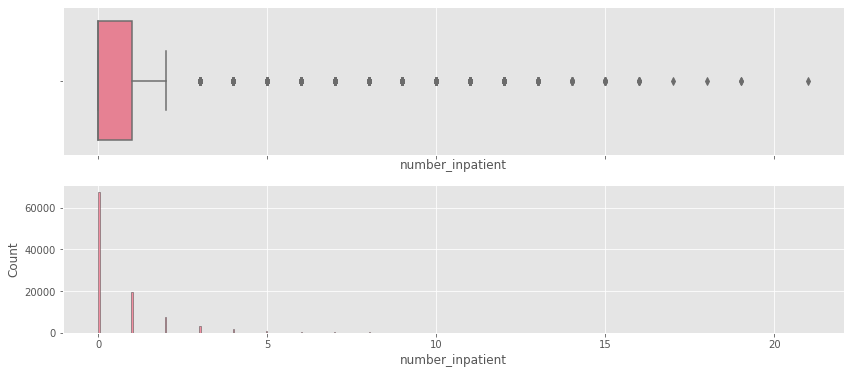

In [50]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_inpatient'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_inpatient",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1]
);

In [51]:
columnas_num.append('number_inpatient')

## Diagnostic 1

In [52]:
display(df_raw['diag_1'].value_counts(normalize=True))

428    0.067429
414    0.064668
786    0.039463
410    0.035513
486    0.034471
         ...   
955    0.000010
318    0.000010
219    0.000010
791    0.000010
V43    0.000010
Name: diag_1, Length: 717, dtype: float64

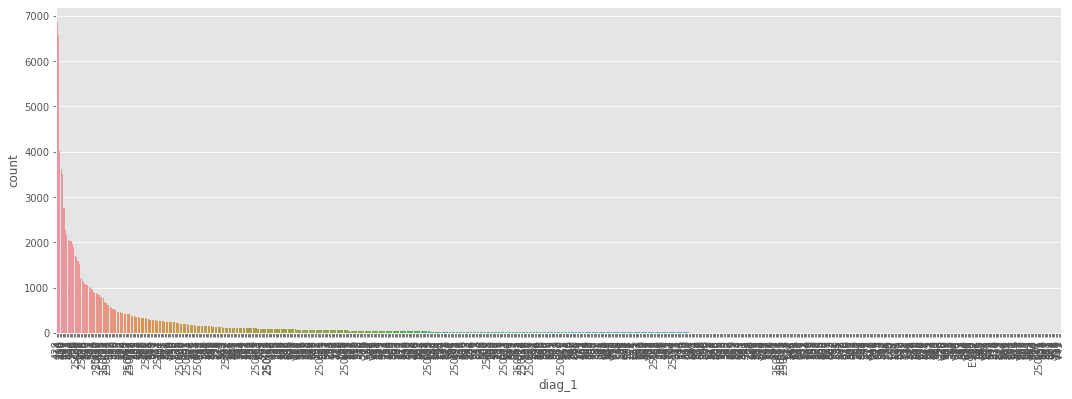

In [53]:
sns.countplot(x=df_raw['diag_1'], 
              order = df_raw['diag_1'].value_counts().index);
plt.xticks(rotation = 90);

In [54]:
columnas_cat_diag.append('diag_1')

## Diagnostic 2

In [55]:
display(df_raw['diag_2'].value_counts(normalize=True))

276     0.066348
428     0.065464
250     0.059656
427     0.049486
401     0.036712
          ...   
E968    0.000010
880     0.000010
E965    0.000010
E938    0.000010
912     0.000010
Name: diag_2, Length: 749, dtype: float64

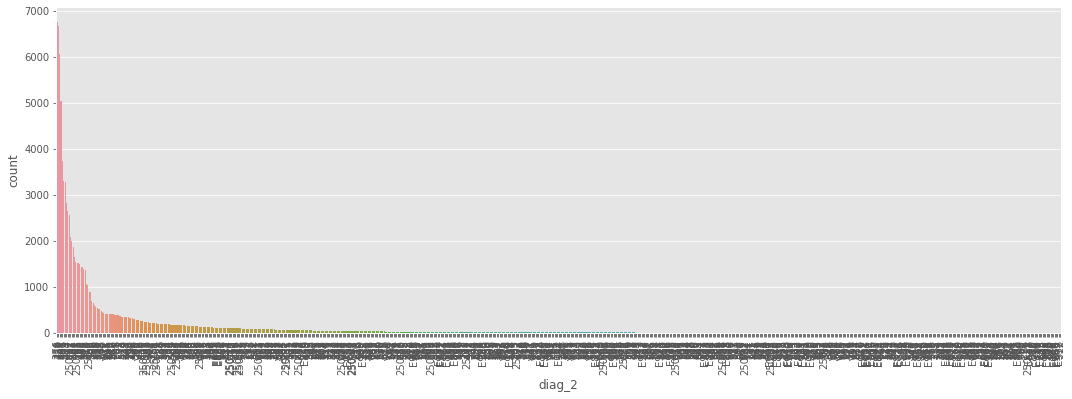

In [56]:
sns.countplot(x=df_raw['diag_2'], 
              order = df_raw['diag_2'].value_counts().index);
plt.xticks(rotation = 90);

In [57]:
columnas_cat_diag.append('diag_2')

## Diagnostic 3

In [58]:
display(df_raw['diag_3'].value_counts(normalize=True))

250    0.113545
401    0.081452
276    0.050852
428    0.044976
427    0.038864
         ...   
115    0.000010
186    0.000010
657    0.000010
602    0.000010
863    0.000010
Name: diag_3, Length: 790, dtype: float64

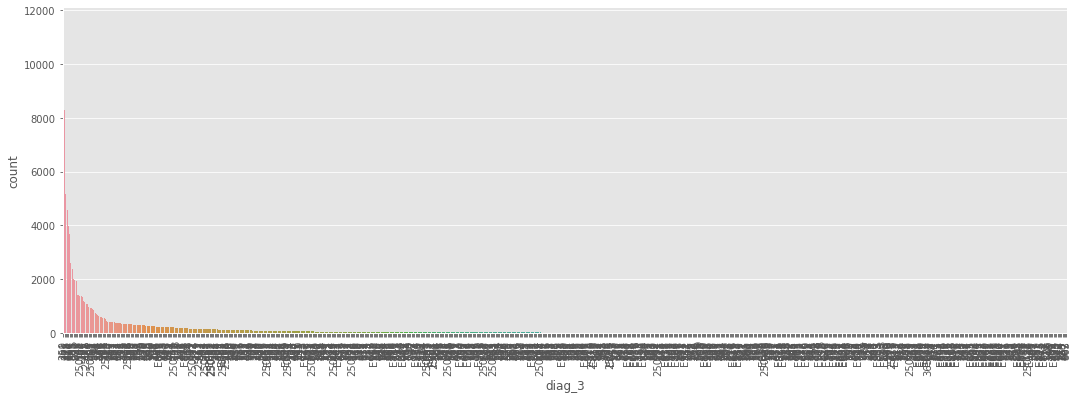

In [59]:
sns.countplot(x=df_raw['diag_3'], 
              order = df_raw['diag_3'].value_counts().index);
plt.xticks(rotation = 90);

In [60]:
columnas_cat_diag.append('diag_3')

## N° diagnoses

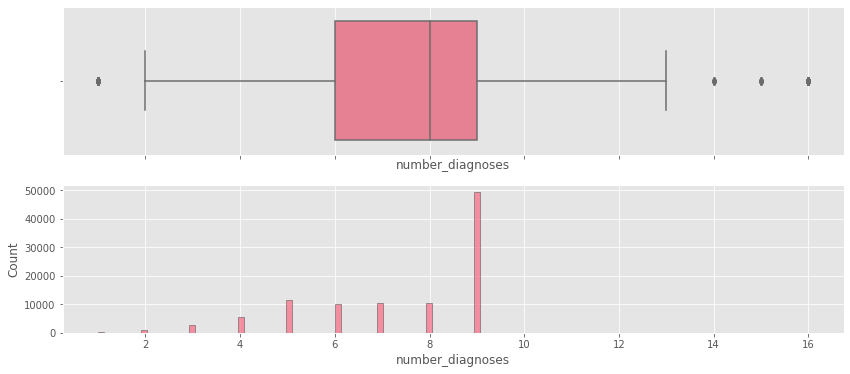

In [61]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_raw['number_diagnoses'], ax=axs[0]);
sns.histplot(
    df_raw,
    x="number_diagnoses",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

In [62]:
columnas_num.append('number_diagnoses')

## max glu serum 

In [63]:
display(df_raw['max_glu_serum'].value_counts(normalize=True))

None    0.947468
Norm    0.025519
>200    0.014592
>300    0.012421
Name: max_glu_serum, dtype: float64

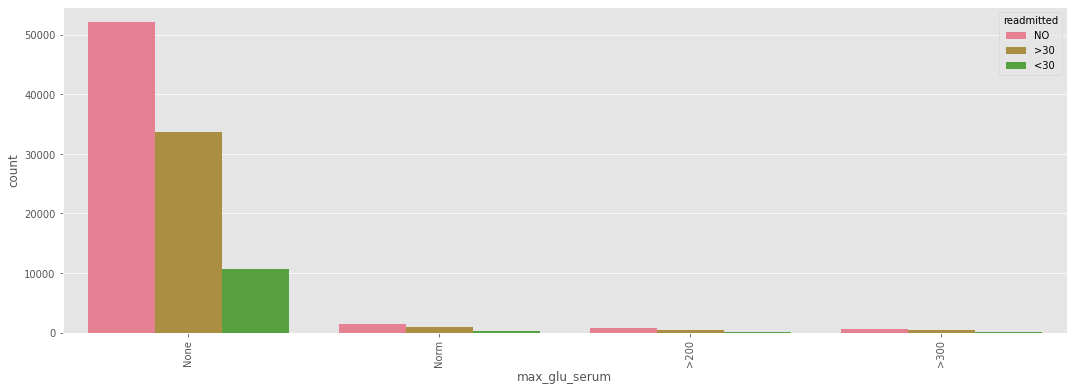

In [64]:
sns.countplot(x = 'max_glu_serum', 
              order = df_raw['max_glu_serum'].value_counts().index,
              data = df_raw,
              hue='readmitted')

plt.xticks(rotation = 90);

In [65]:
columnas_dropear.append('max_glu_serum')

## A1 Cresult

In [66]:
display(df_raw['A1Cresult'].value_counts(normalize=True))

None    0.832773
>8      0.080734
Norm    0.049034
>7      0.037458
Name: A1Cresult, dtype: float64

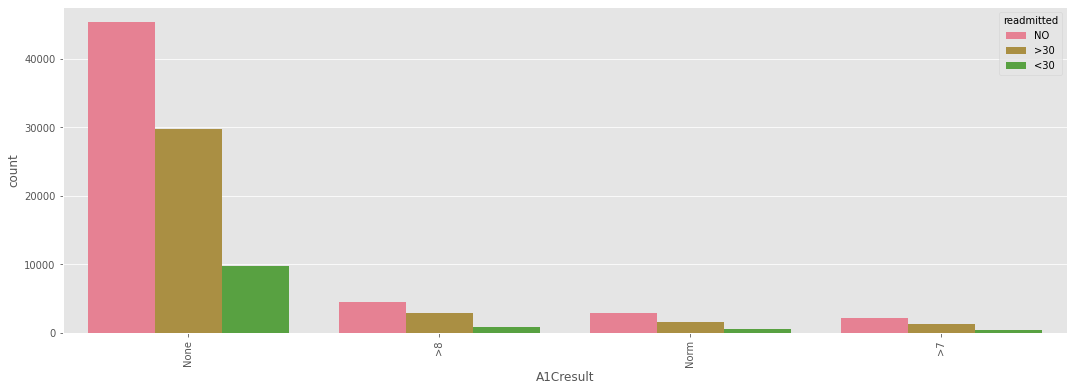

In [67]:
sns.countplot(x = 'A1Cresult', 
              order = df_raw['A1Cresult'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [68]:
columnas_cat.append('A1Cresult')

## Metformin

In [69]:
display(df_raw['metformin'].value_counts(normalize=True))

No        0.803589
Steady    0.180276
Up        0.010485
Down      0.005650
Name: metformin, dtype: float64

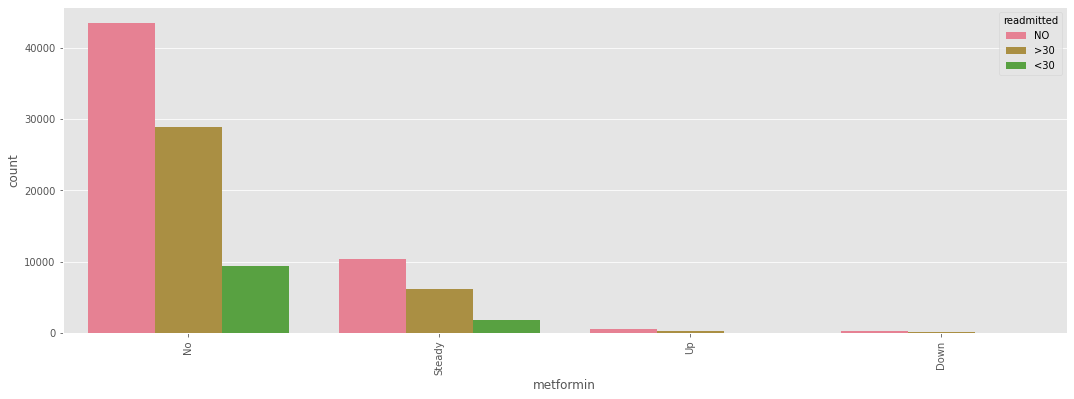

In [70]:
sns.countplot(x = 'metformin', 
              order = df_raw['metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [71]:
columnas_cat.append('metformin')

## Repaglinide

In [72]:
display(df_raw['repaglinide'].value_counts(normalize=True))

No        0.984877
Steady    0.013600
Up        0.001081
Down      0.000442
Name: repaglinide, dtype: float64

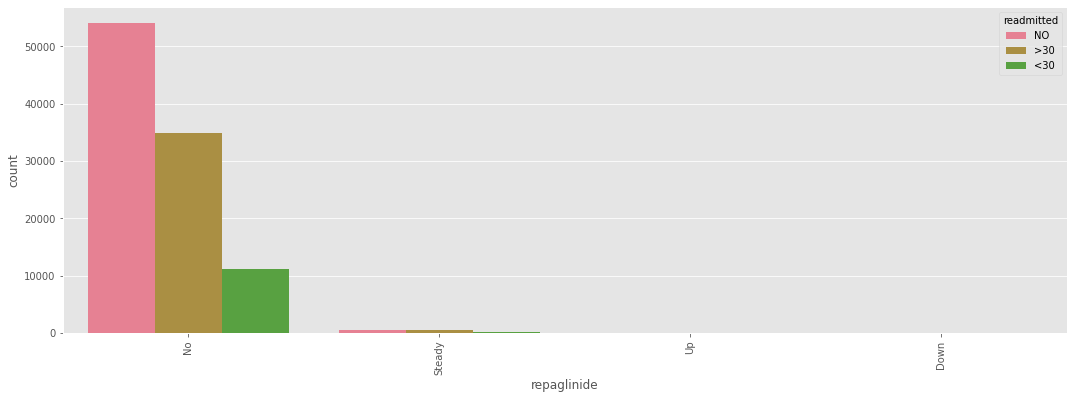

In [73]:
sns.countplot(x = 'repaglinide', 
              order = df_raw['repaglinide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [74]:
columnas_dropear.append('repaglinide')

## Nateglinide

In [75]:
display(df_raw['nateglinide'].value_counts(normalize=True))

No        0.993092
Steady    0.006564
Up        0.000236
Down      0.000108
Name: nateglinide, dtype: float64

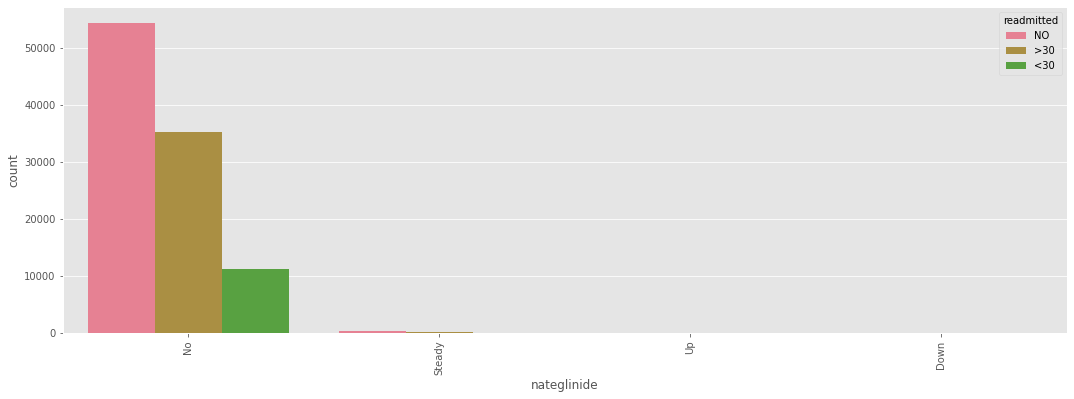

In [76]:
sns.countplot(x = 'nateglinide', 
              order = df_raw['nateglinide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [77]:
columnas_dropear.append('nateglinide')

## Chlorpropamide

In [78]:
display(df_raw['chlorpropamide'].value_counts(normalize=True))

No        0.999155
Steady    0.000776
Up        0.000059
Down      0.000010
Name: chlorpropamide, dtype: float64

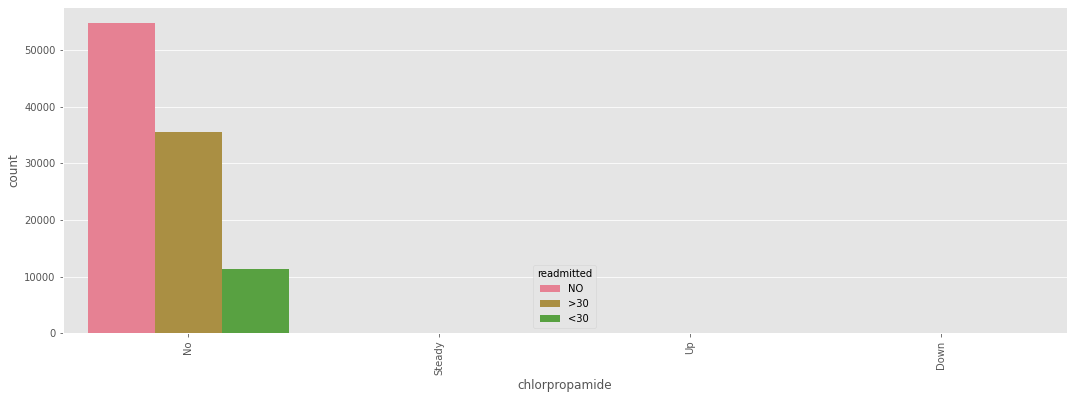

In [79]:
sns.countplot(x = 'chlorpropamide', 
              order = df_raw['chlorpropamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [80]:
columnas_dropear.append('chlorpropamide')

## Glimepiride

In [81]:
display(df_raw['glimepiride'].value_counts(normalize=True))

No        0.948991
Steady    0.045890
Up        0.003213
Down      0.001906
Name: glimepiride, dtype: float64

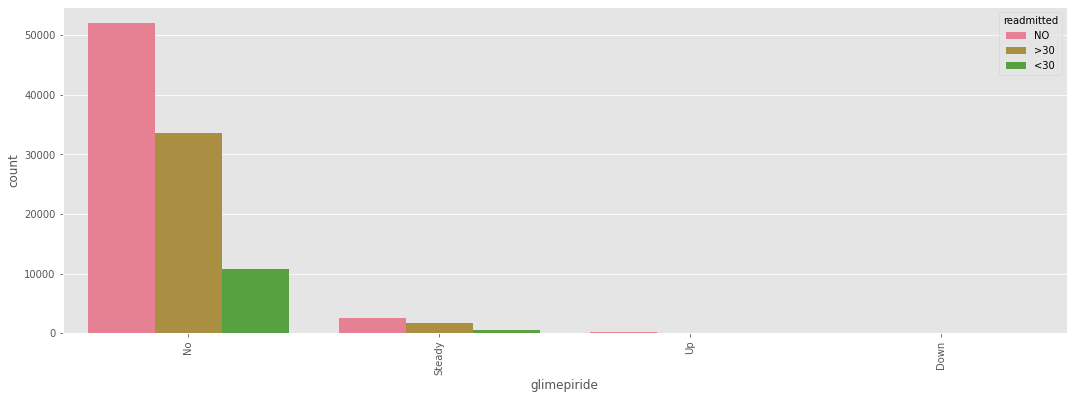

In [82]:
sns.countplot(x = 'glimepiride', 
              order = df_raw['glimepiride'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [83]:
columnas_dropear.append('glimepiride')

## Acetohexamide

In [84]:
display(df_raw['acetohexamide'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: acetohexamide, dtype: float64

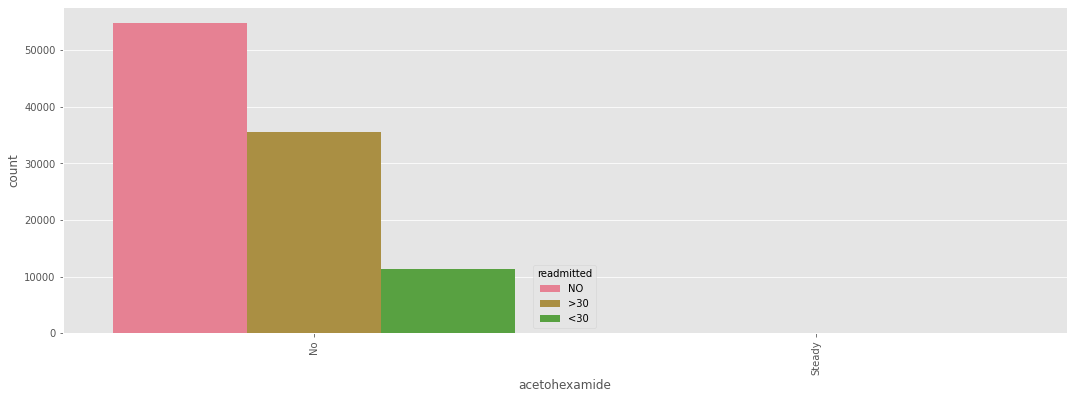

In [85]:
sns.countplot(x = 'acetohexamide', 
              order = df_raw['acetohexamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [86]:
columnas_dropear.append('acetohexamide')

## Glyburide

In [87]:
display(df_raw['glyburide'].value_counts(normalize=True))

No        0.895348
Steady    0.091131
Up        0.007979
Down      0.005542
Name: glyburide, dtype: float64

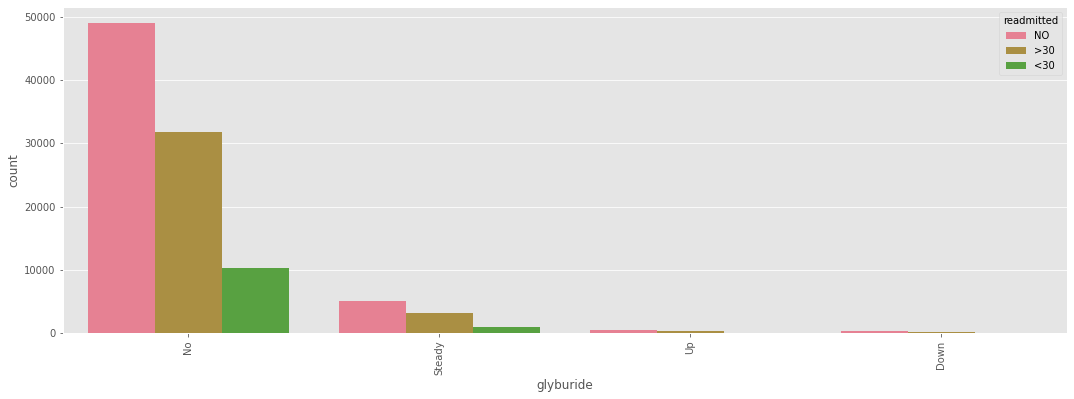

In [88]:
sns.countplot(x = 'glyburide', 
              order = df_raw['glyburide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [89]:
columnas_cat.append('glyburide')

## Tolbutamide 

In [90]:
display(df_raw['tolbutamide'].value_counts(normalize=True))

No        0.999774
Steady    0.000226
Name: tolbutamide, dtype: float64

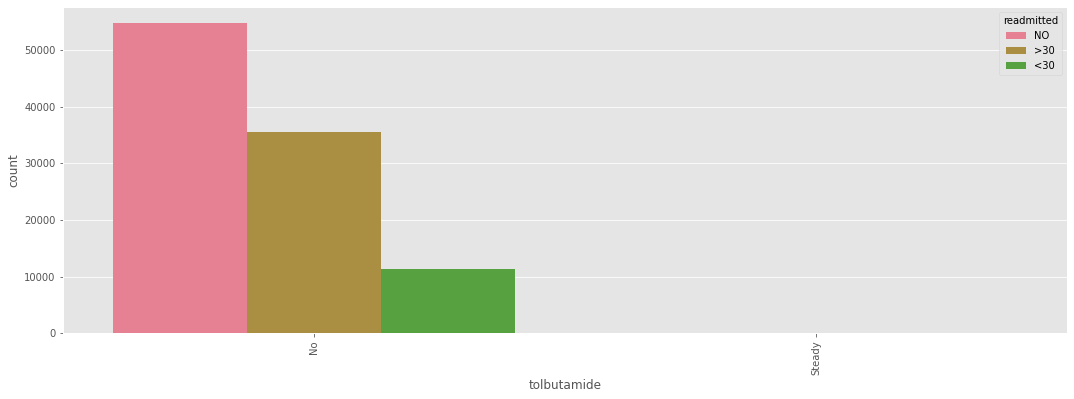

In [91]:
sns.countplot(x = 'tolbutamide', 
              order = df_raw['tolbutamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [92]:
columnas_dropear.append('tolbutamide')

## Pioglitazone

In [93]:
display(df_raw['pioglitazone'].value_counts(normalize=True))

No        0.927992
Steady    0.068549
Up        0.002299
Down      0.001160
Name: pioglitazone, dtype: float64

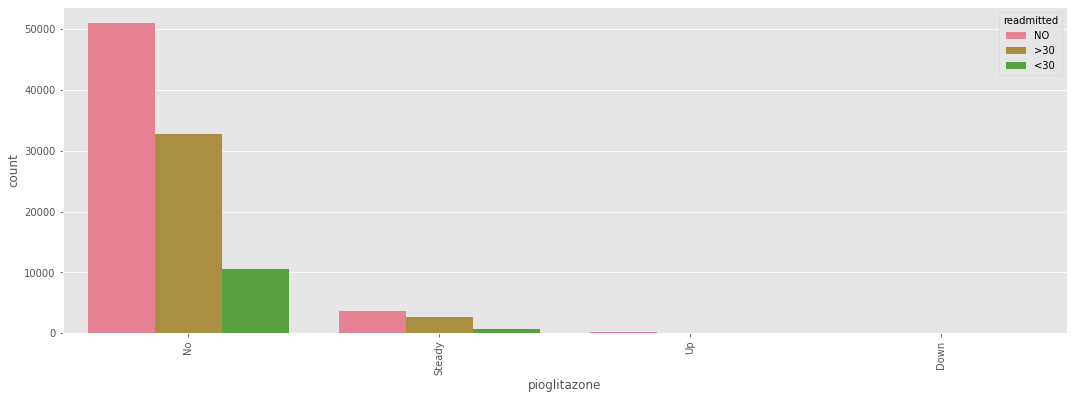

In [94]:
sns.countplot(x = 'pioglitazone', 
              order = df_raw['pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [95]:
columnas_dropear.append('pioglitazone')

## Rosiglitazone

In [96]:
display(df_raw['rosiglitazone'].value_counts(normalize=True))

No        0.937455
Steady    0.059941
Up        0.001749
Down      0.000855
Name: rosiglitazone, dtype: float64

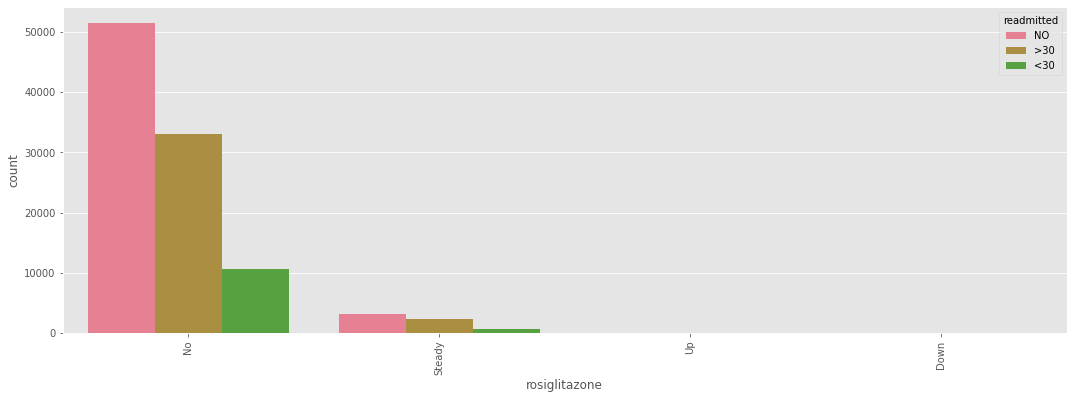

In [97]:
sns.countplot(x = 'rosiglitazone', 
              order = df_raw['rosiglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [98]:
columnas_dropear.append('rosiglitazone')

## Acarbose

In [99]:
display(df_raw['acarbose'].value_counts(normalize=True))

No        0.996973
Steady    0.002899
Up        0.000098
Down      0.000029
Name: acarbose, dtype: float64

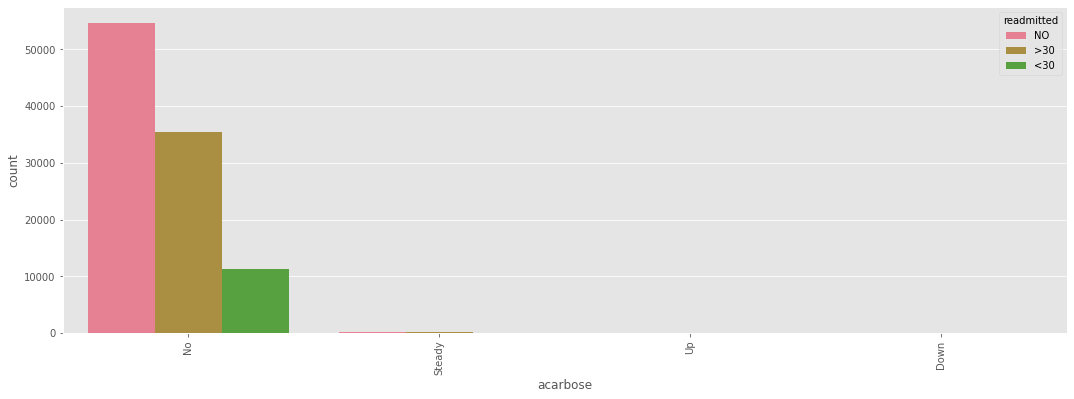

In [100]:
sns.countplot(x = 'acarbose', 
              order = df_raw['acarbose'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [101]:
columnas_dropear.append('acarbose')

## Miglitol

In [102]:
display(df_raw['miglitol'].value_counts(normalize=True))

No        0.999627
Steady    0.000305
Down      0.000049
Up        0.000020
Name: miglitol, dtype: float64

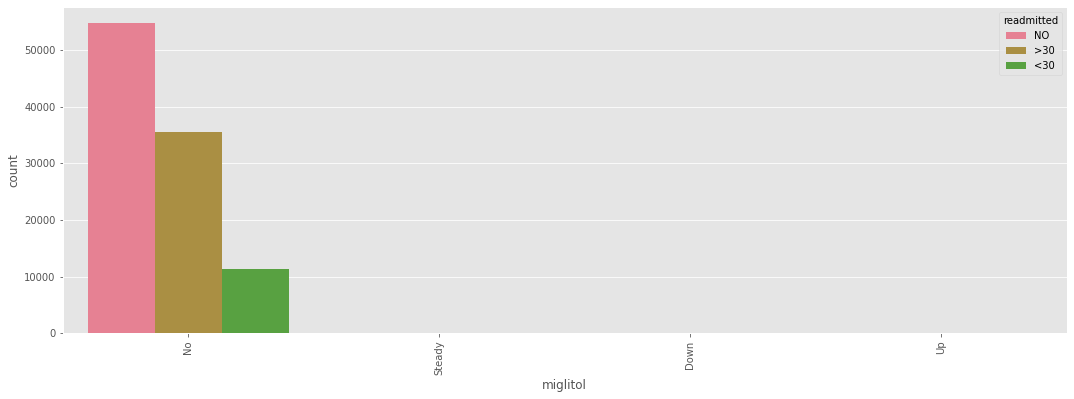

In [103]:
sns.countplot(x = 'miglitol', 
              order = df_raw['miglitol'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [104]:
columnas_dropear.append('miglitol')

## Troglitazone

In [105]:
display(df_raw['troglitazone'].value_counts(normalize=True))

No        0.999971
Steady    0.000029
Name: troglitazone, dtype: float64

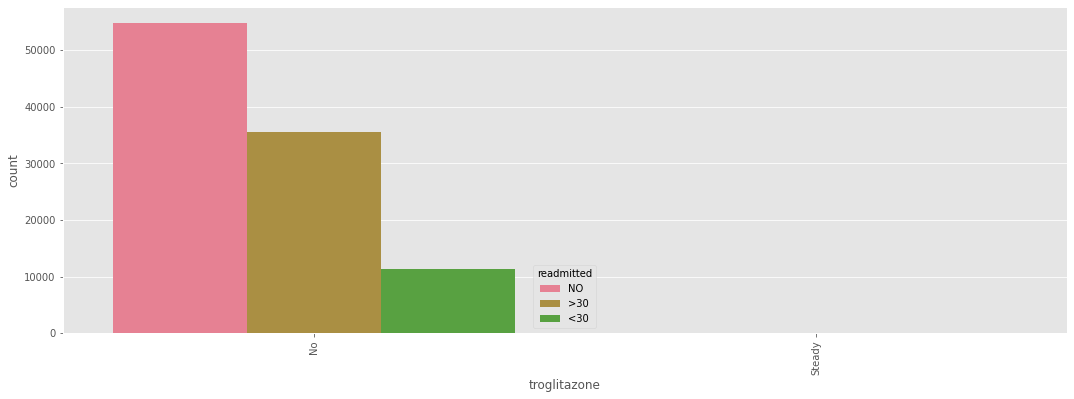

In [106]:
sns.countplot(x = 'troglitazone', 
              order = df_raw['troglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [107]:
columnas_dropear.append('troglitazone')

## Tolazamide

In [108]:
display(df_raw['tolazamide'].value_counts(normalize=True))

No        0.999617
Steady    0.000373
Up        0.000010
Name: tolazamide, dtype: float64

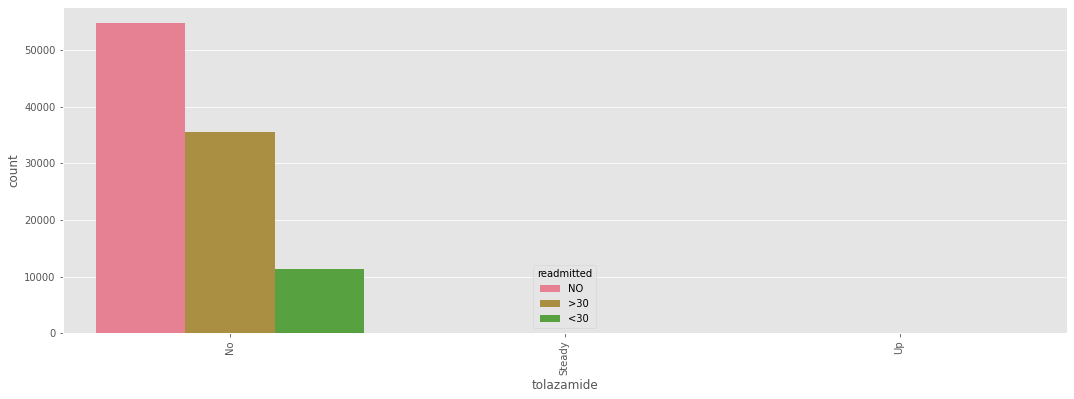

In [109]:
sns.countplot(x = 'tolazamide', 
              order = df_raw['tolazamide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [110]:
columnas_dropear.append('tolazamide')

## Examide

In [111]:
display(df_raw['examide'].value_counts(normalize=True))

No    1.0
Name: examide, dtype: float64

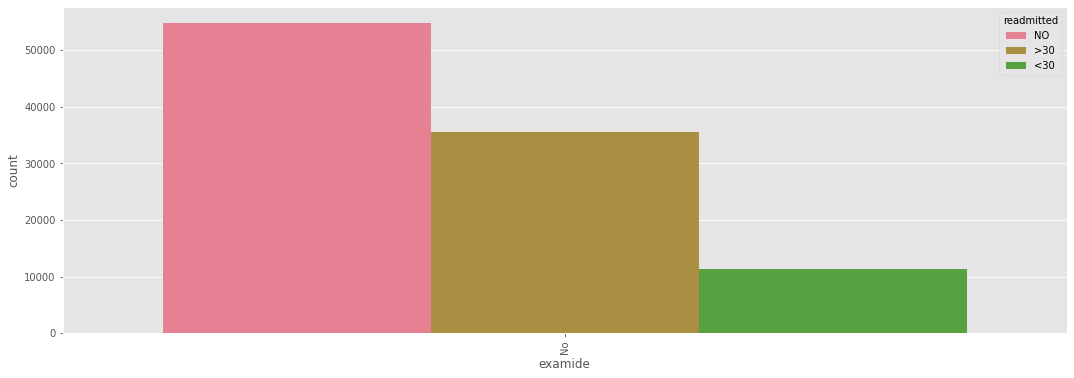

In [112]:
sns.countplot(x = 'examide', 
              order = df_raw['examide'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [113]:
columnas_dropear.append('examide')

## Citoglipton

In [114]:
display(df_raw['citoglipton'].value_counts(normalize=True))

No    1.0
Name: citoglipton, dtype: float64

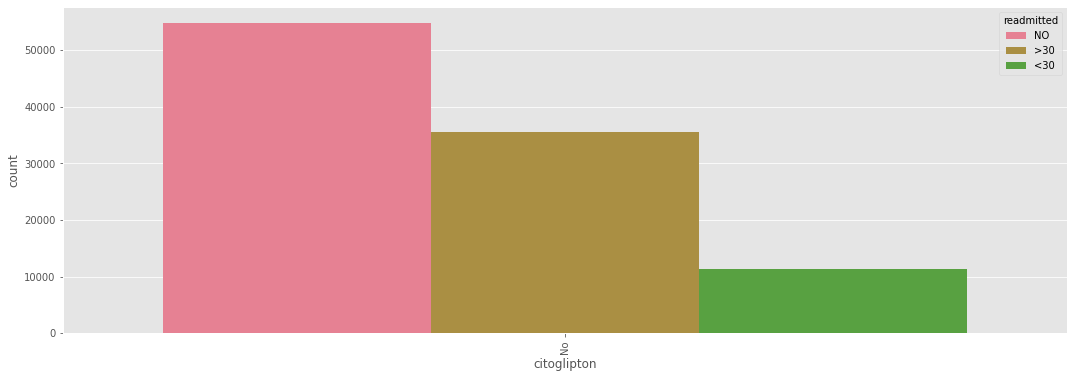

In [115]:
sns.countplot(x = 'citoglipton', 
              order = df_raw['citoglipton'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [116]:
columnas_dropear.append('citoglipton')

## Insulin

In [117]:
display(df_raw['insulin'].value_counts(normalize=True))

No        0.465607
Steady    0.303137
Down      0.120060
Up        0.111196
Name: insulin, dtype: float64

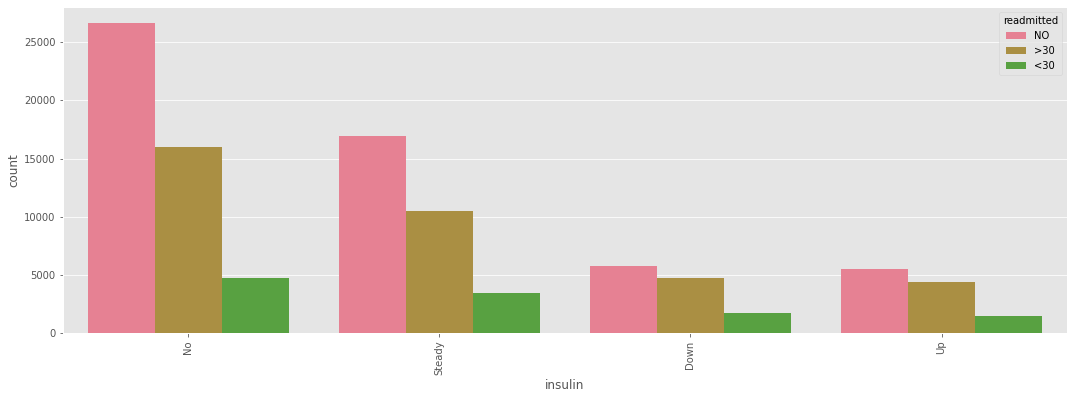

In [118]:
sns.countplot(x = 'insulin', 
              order = df_raw['insulin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [119]:
columnas_cat.append('insulin')

## Glyburide-metformin

In [120]:
display(df_raw['glyburide-metformin'].value_counts(normalize=True))

No        0.993063
Steady    0.006800
Up        0.000079
Down      0.000059
Name: glyburide-metformin, dtype: float64

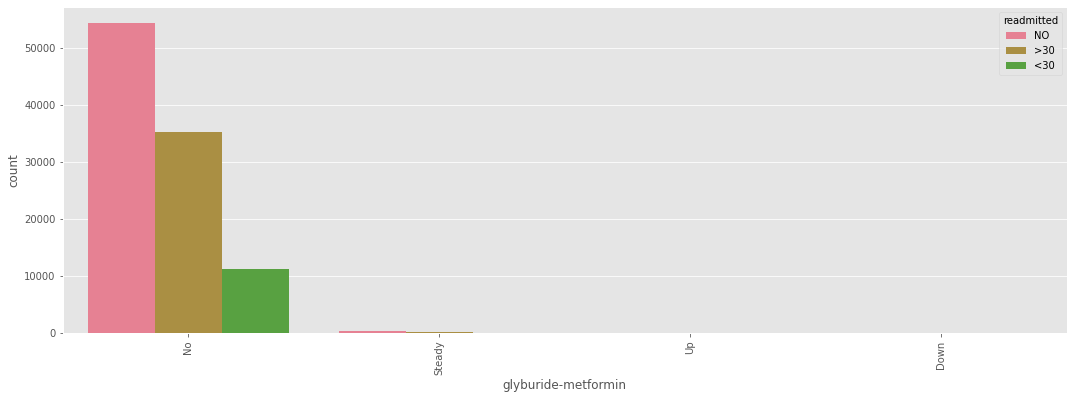

In [121]:
sns.countplot(x = 'glyburide-metformin', 
              order = df_raw['glyburide-metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [122]:
columnas_dropear.append('glyburide-metformin')

## Glipizide-metformin

In [123]:
display(df_raw['glipizide-metformin'].value_counts(normalize=True))

No        0.999872
Steady    0.000128
Name: glipizide-metformin, dtype: float64

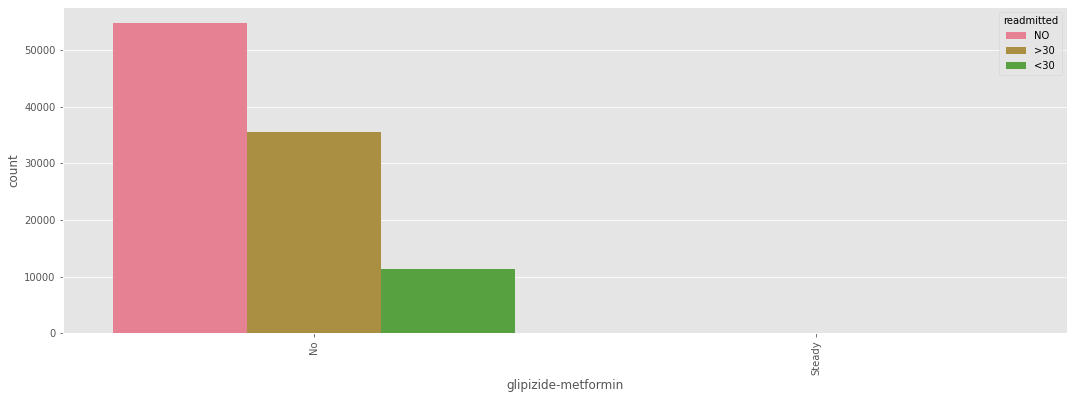

In [124]:
sns.countplot(x = 'glipizide-metformin', 
              order = df_raw['glipizide-metformin'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [125]:
columnas_dropear.append('glipizide-metformin')

## Glimepiride-pioglitazone

In [126]:
display(df_raw['glimepiride-pioglitazone'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: glimepiride-pioglitazone, dtype: float64

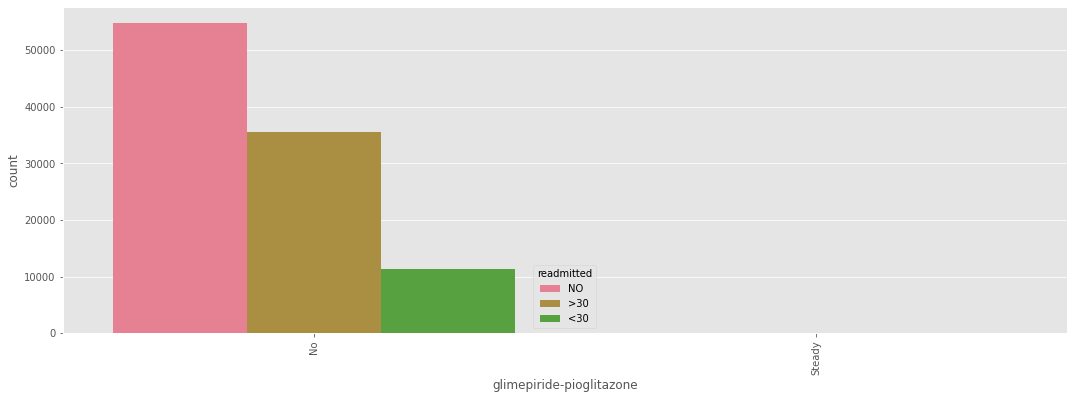

In [127]:
sns.countplot(x = 'glimepiride-pioglitazone', 
              order = df_raw['glimepiride-pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [128]:
columnas_dropear.append('glimepiride-pioglitazone')

## Metformin-rosiglitazone

In [129]:
display(df_raw['metformin-rosiglitazone'].value_counts(normalize=True))

No        0.99998
Steady    0.00002
Name: metformin-rosiglitazone, dtype: float64

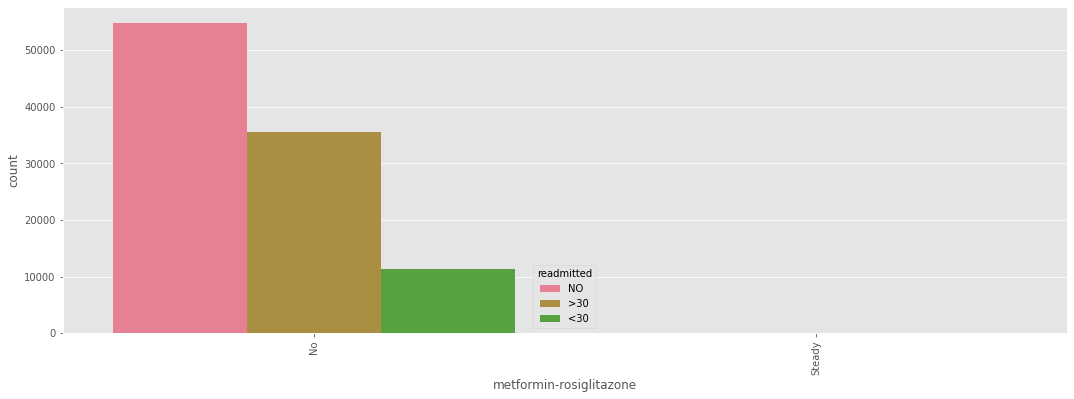

In [130]:
sns.countplot(x = 'metformin-rosiglitazone', 
              order = df_raw['metformin-rosiglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [131]:
columnas_dropear.append('metformin-rosiglitazone')

## Metformin-pioglitazone

In [132]:
display(df_raw['metformin-pioglitazone'].value_counts(normalize=True))

No        0.99999
Steady    0.00001
Name: metformin-pioglitazone, dtype: float64

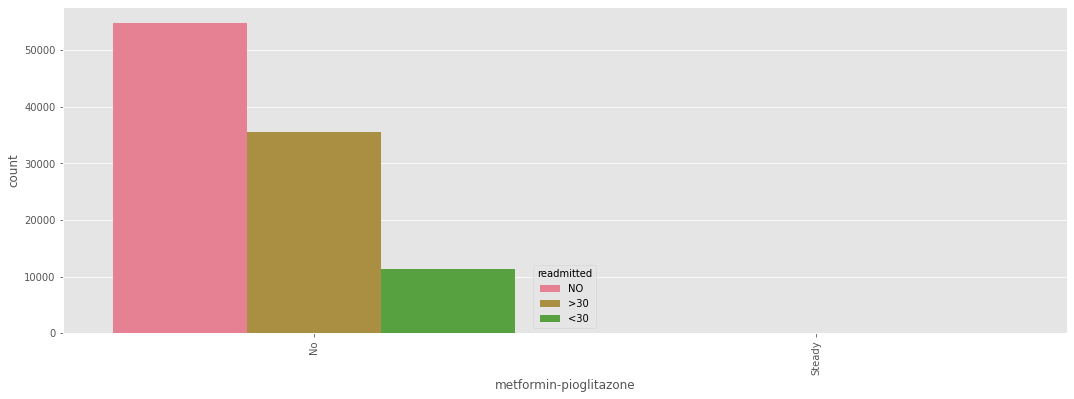

In [133]:
sns.countplot(x = 'metformin-pioglitazone', 
              order = df_raw['metformin-pioglitazone'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [134]:
columnas_dropear.append('metformin-pioglitazone')

## Change

In [135]:
display(df_raw['change'].value_counts(normalize=True))

No    0.538048
Ch    0.461952
Name: change, dtype: float64

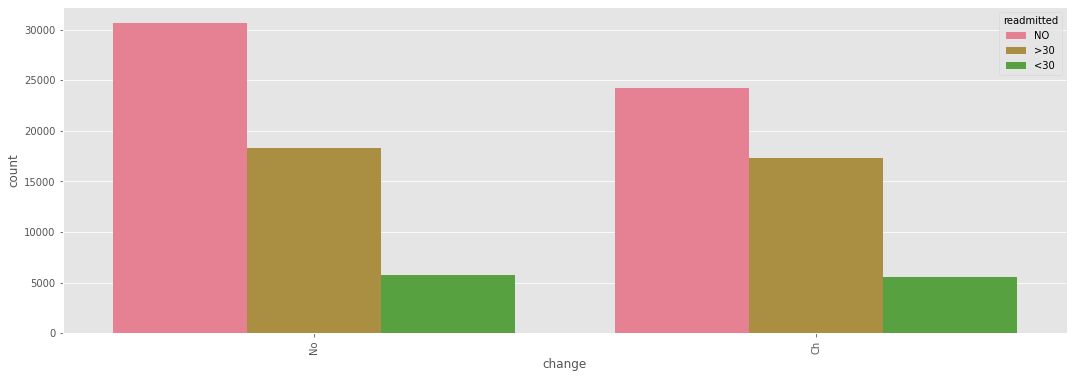

In [136]:
sns.countplot(x = 'change', 
              order = df_raw['change'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [137]:
columnas_cat.append('change')

## DiabetesMed 

In [138]:
display(df_raw['diabetesMed'].value_counts(normalize=True))

Yes    0.770031
No     0.229969
Name: diabetesMed, dtype: float64

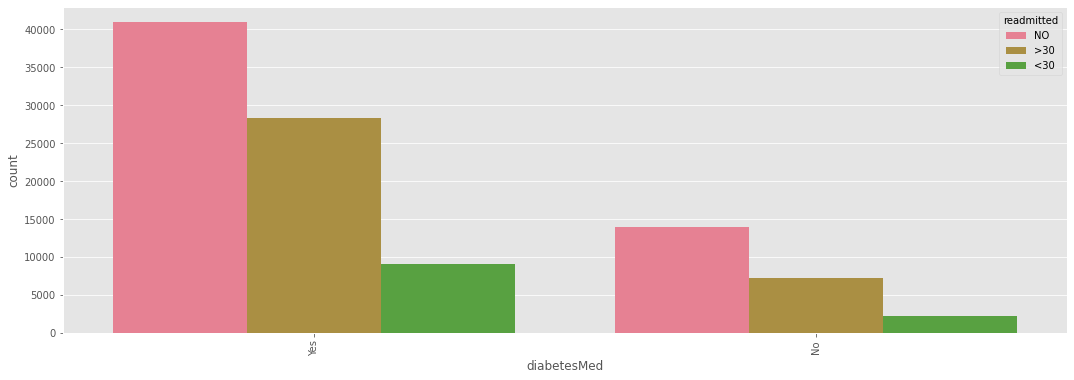

In [139]:
sns.countplot(x = 'diabetesMed', 
              order = df_raw['diabetesMed'].value_counts().index,
              data = df_raw,
              hue='readmitted')
plt.xticks(rotation = 90);

In [140]:
columnas_cat.append('diabetesMed')

## Readmitted (target)

In [141]:
display(df_raw['readmitted'].value_counts(normalize=True))

NO     0.539119
>30    0.349282
<30    0.111599
Name: readmitted, dtype: float64

In [142]:
columnas_cat.append('readmitted')

# Limpieza de datos

## Outliers IQR

In [143]:
def remover_IQR(dataset, column):
    Q1 = dataset[column].quantile(0.25)
    Q3 = dataset[column].quantile(0.75)
    IQR = Q3 - Q1
    df = dataset[~((dataset[column] < (Q1 - 1.5 * IQR)) |(dataset[column] > (Q3 + 1.5 * IQR)))]
    return df

## Columnas disponibles

In [144]:
columnas_cat

['race',
 'gender',
 'age',
 'admission_type_id',
 'discharge_disposition_id',
 'admission_source_id',
 'time_in_hospital',
 'payer_code',
 'num_procedures',
 'A1Cresult',
 'metformin',
 'glyburide',
 'insulin',
 'change',
 'diabetesMed',
 'readmitted']

In [145]:
columnas_num

['num_medications', 'number_inpatient', 'number_diagnoses']

In [146]:
df_sin_limpiar = df_raw[columnas_cat + columnas_num]

In [147]:
df_sin_limpiar.isnull().sum()

race                        0
gender                      0
age                         0
admission_type_id           0
discharge_disposition_id    0
admission_source_id         0
time_in_hospital            0
payer_code                  0
num_procedures              0
A1Cresult                   0
metformin                   0
glyburide                   0
insulin                     0
change                      0
diabetesMed                 0
readmitted                  0
num_medications             0
number_inpatient            0
number_diagnoses            0
dtype: int64

In [148]:
df_sin_limpiar.dtypes

race                        object
gender                      object
age                         object
admission_type_id            int64
discharge_disposition_id     int64
admission_source_id          int64
time_in_hospital             int64
payer_code                  object
num_procedures               int64
A1Cresult                   object
metformin                   object
glyburide                   object
insulin                     object
change                      object
diabetesMed                 object
readmitted                  object
num_medications              int64
number_inpatient             int64
number_diagnoses             int64
dtype: object

## Race

In [149]:
df_sin_limpiar['race'].value_counts()

Caucasian          76099
AfricanAmerican    19210
?                   2273
Hispanic            2037
Other               1506
Asian                641
Name: race, dtype: int64

In [150]:
df_sin_limpiar.loc[df_sin_limpiar['race'] != 'Caucasian', 'race'] = 'Not Caucasian'

In [151]:
df_sin_limpiar['race'].value_counts()

Caucasian        76099
Not Caucasian    25667
Name: race, dtype: int64

## Gender

In [152]:
df_sin_limpiar['gender'].value_counts()

Female             54708
Male               47055
Unknown/Invalid        3
Name: gender, dtype: int64

In [153]:
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['gender'] == 'Unknown/Invalid'].index, inplace=True)

In [154]:
df_sin_limpiar['gender'].value_counts()

Female    54708
Male      47055
Name: gender, dtype: int64

## Age

In [155]:
df_sin_limpiar['age'].value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
[10-20)       691
[0-10)        161
Name: age, dtype: int64

In [156]:
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['age'] == '[10-20)'].index, inplace=True)
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['age'] == '[0-10)'].index, inplace=True)

In [157]:
df_sin_limpiar['age'].value_counts()

[70-80)     26066
[60-70)     22482
[50-60)     17256
[80-90)     17197
[40-50)      9685
[30-40)      3775
[90-100)     2793
[20-30)      1657
Name: age, dtype: int64

## Admission type id

In [158]:
df_sin_limpiar['admission_type_id'].value_counts()

1    53441
3    18763
2    18344
6     5240
5     4775
8      319
7       20
4        9
Name: admission_type_id, dtype: int64

In [159]:
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['admission_type_id'] == 8].index, inplace=True)
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['admission_type_id'] == 7].index, inplace=True)
df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['admission_type_id'] == 4].index, inplace=True)

In [160]:
df_sin_limpiar['admission_type_id'].value_counts()

1    53441
3    18763
2    18344
6     5240
5     4775
Name: admission_type_id, dtype: int64

## Discharge disposition id

In [161]:
df_sin_limpiar['discharge_disposition_id'].value_counts(normalize=True)

1     0.588646
3     0.138580
6     0.127651
18    0.036674
2     0.021061
22    0.019769
11    0.016278
5     0.011724
25    0.009497
4     0.008104
7     0.006026
23    0.004097
13    0.003968
14    0.003699
28    0.001382
8     0.001054
15    0.000626
24    0.000477
9     0.000199
17    0.000139
16    0.000109
19    0.000080
10    0.000060
27    0.000050
12    0.000030
20    0.000020
Name: discharge_disposition_id, dtype: float64

In [162]:
nums = df_sin_limpiar['discharge_disposition_id'].value_counts(normalize=True).index
not_drop = [1, 3, 6]

for v in nums:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['discharge_disposition_id'] == v].index, inplace=True)

In [163]:
df_sin_limpiar['discharge_disposition_id'].value_counts(normalize=True)

1    0.688574
3    0.162105
6    0.149321
Name: discharge_disposition_id, dtype: float64

## Admission source id

In [164]:
df_sin_limpiar['admission_source_id'].value_counts(normalize=True)

7     0.563773
1     0.297468
17    0.066664
4     0.027591
6     0.022369
2     0.009945
5     0.007584
20    0.001803
9     0.001338
3     0.001059
22    0.000128
8     0.000116
10    0.000093
11    0.000023
25    0.000023
13    0.000012
14    0.000012
Name: admission_source_id, dtype: float64

In [165]:
nums = df_sin_limpiar['admission_source_id'].value_counts(normalize=True).index
not_drop = [7, 1, 17]

for v in nums:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['admission_source_id'] == v].index, inplace=True)

In [166]:
df_sin_limpiar['admission_source_id'].value_counts(normalize=True)

7     0.607577
1     0.320580
17    0.071843
Name: admission_source_id, dtype: float64

## Time in hospital

In [167]:
df_sin_limpiar['time_in_hospital'].value_counts(normalize=True)

3     0.180705
2     0.176305
1     0.142357
4     0.139813
5     0.097642
6     0.072620
7     0.056010
8     0.040804
9     0.026927
10    0.020333
11    0.015758
12    0.012323
13    0.010104
14    0.008299
Name: time_in_hospital, dtype: float64

In [168]:
nums = df_sin_limpiar['time_in_hospital'].value_counts(normalize=True).index
not_drop = [3, 2, 1, 4, 5, 6, 7, 8]

for v in nums:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['time_in_hospital'] == v].index, inplace=True)

In [169]:
df_sin_limpiar['time_in_hospital'].value_counts(normalize=True)

3    0.199397
2    0.194542
1    0.157083
4    0.154275
5    0.107742
6    0.080132
7    0.061804
8    0.045025
Name: time_in_hospital, dtype: float64

## Payer code

In [170]:
df_sin_limpiar['payer_code'].value_counts(normalize=True)

?     0.350615
MC    0.335468
HM    0.068236
SP    0.056022
BC    0.053186
MD    0.035328
CP    0.028274
CM    0.021358
UN    0.021233
OG    0.011592
PO    0.006902
DM    0.005990
CH    0.001771
WC    0.001618
OT    0.001107
MP    0.000650
SI    0.000650
Name: payer_code, dtype: float64

In [171]:
df_sin_limpiar['payer_code'] = df_sin_limpiar['payer_code'].str.replace('?', 'NN', regex=False)

In [172]:
codes = df_sin_limpiar['payer_code'].value_counts(normalize=True).index
not_drop = ['NN', 'MC', 'HM', 'SP', 'BC', 'MD', 'CP', 'UN', 'CM']

for v in codes:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['payer_code'] == v].index, inplace=True)

In [173]:
df_sin_limpiar['payer_code'].value_counts(normalize=True)

NN    0.361563
MC    0.345943
HM    0.070367
SP    0.057771
BC    0.054847
MD    0.036432
CP    0.029157
CM    0.022024
UN    0.021896
Name: payer_code, dtype: float64

## N° procedures

In [174]:
df_sin_limpiar['num_procedures'].value_counts(normalize=True)

0    0.483425
1    0.209959
2    0.119066
3    0.084617
6    0.041624
4    0.035761
5    0.025548
Name: num_procedures, dtype: float64

In [175]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'num_procedures')

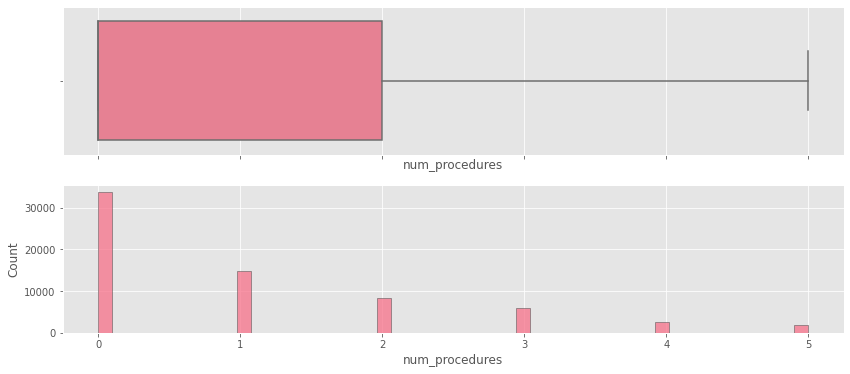

In [176]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['num_procedures'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="num_procedures",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## Nº Inpatient

In [177]:
df_sin_limpiar['number_inpatient'].value_counts(normalize=True)

0     0.664454
1     0.192555
2     0.074271
3     0.032745
4     0.015613
5     0.008276
6     0.004852
7     0.002739
8     0.001488
9     0.001161
10    0.000566
11    0.000506
12    0.000268
13    0.000193
15    0.000089
16    0.000089
14    0.000074
19    0.000030
18    0.000015
21    0.000015
Name: number_inpatient, dtype: float64

In [178]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'number_inpatient')

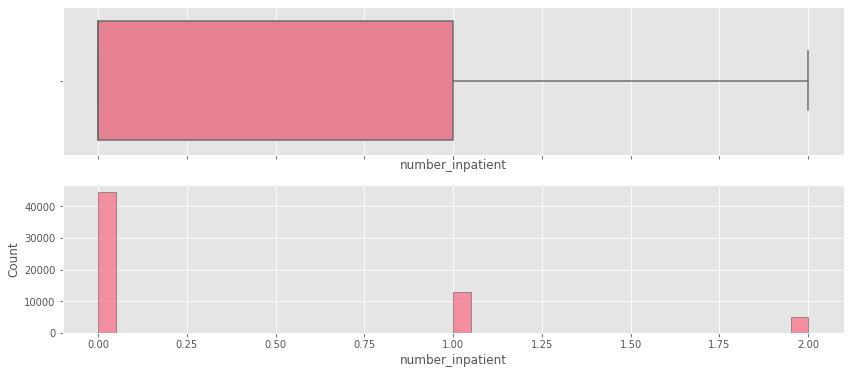

In [179]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['number_inpatient'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="number_inpatient",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## Nº Medications

In [180]:
df_sin_limpiar['num_medications'].value_counts(normalize=True)

12    0.065176
13    0.064601
11    0.063258
15    0.060813
14    0.060206
        ...   
63    0.000048
65    0.000032
59    0.000016
68    0.000016
62    0.000016
Name: num_medications, Length: 64, dtype: float64

In [181]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'num_medications')

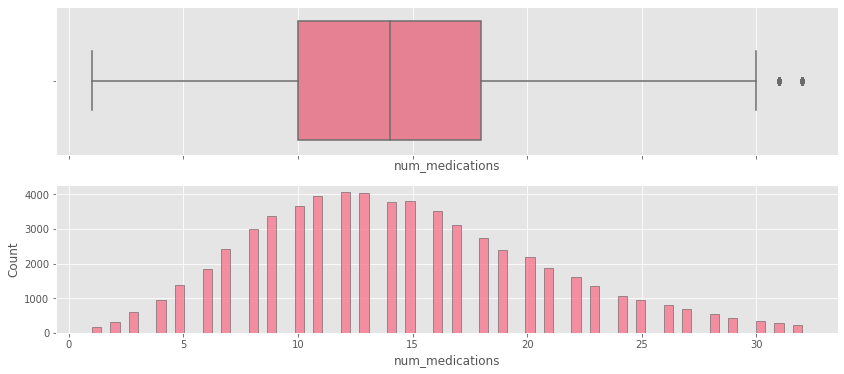

In [182]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['num_medications'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="num_medications",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## Nº Diagnoses

In [183]:
df_sin_limpiar['number_diagnoses'].value_counts(normalize=True)

9     0.468554
7     0.109265
8     0.108159
6     0.107964
5     0.102826
4     0.059835
3     0.031251
2     0.010016
1     0.000943
16    0.000406
10    0.000195
11    0.000163
13    0.000163
15    0.000114
12    0.000098
14    0.000049
Name: number_diagnoses, dtype: float64

In [184]:
df_sin_limpiar = remover_IQR(df_sin_limpiar, 'number_diagnoses')

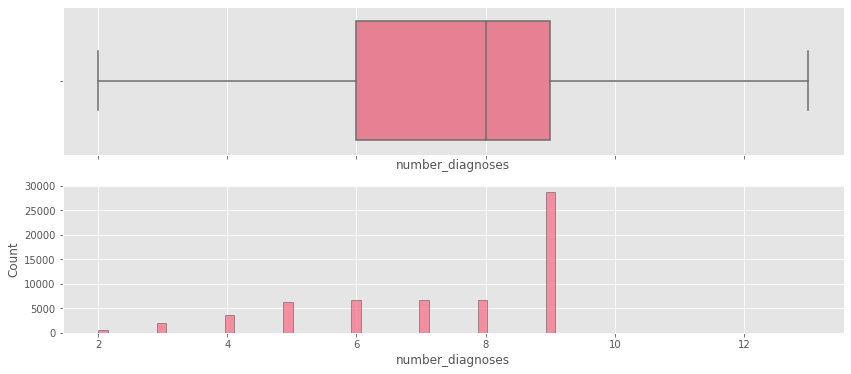

In [185]:
fig, axs = plt.subplots(2, figsize = (14,6), sharex = True)

sns.boxplot(x=df_sin_limpiar['number_diagnoses'], ax=axs[0]);
sns.histplot(
    df_sin_limpiar,
    x="number_diagnoses",
    multiple="stack",
    edgecolor=".3",
    linewidth=.5,
    ax=axs[1],
);

## A1 Cresult

In [186]:
df_sin_limpiar['A1Cresult'].value_counts(normalize=True)

None    0.837239
>8      0.076503
Norm    0.047990
>7      0.038268
Name: A1Cresult, dtype: float64

## Metformin

In [187]:
df_sin_limpiar['metformin'].value_counts(normalize=True)

No        0.787653
Steady    0.196388
Up        0.009982
Down      0.005976
Name: metformin, dtype: float64

In [188]:
nums = df_sin_limpiar['metformin'].value_counts(normalize=True).index
not_drop = ['No', 'Steady']

for v in nums:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['metformin'] == v].index, inplace=True)

In [189]:
df_sin_limpiar['metformin'].value_counts(normalize=True)

No        0.800427
Steady    0.199573
Name: metformin, dtype: float64

## Glyburide

In [190]:
df_sin_limpiar['glyburide'].value_counts(normalize=True)

No        0.898410
Steady    0.090900
Up        0.006239
Down      0.004452
Name: glyburide, dtype: float64

In [191]:
nums = df_sin_limpiar['glyburide'].value_counts(normalize=True).index
not_drop = ['No', 'Steady']

for v in nums:
    if v not in not_drop:
        df_sin_limpiar.drop(df_sin_limpiar[df_sin_limpiar['glyburide'] == v].index, inplace=True)

In [192]:
df_sin_limpiar['glyburide'].value_counts(normalize=True)

No        0.908118
Steady    0.091882
Name: glyburide, dtype: float64

## Insulin

In [193]:
df_sin_limpiar['insulin'].value_counts(normalize=True)

No        0.486476
Steady    0.297442
Down      0.113527
Up        0.102554
Name: insulin, dtype: float64

## Change

In [194]:
df_sin_limpiar['change'].value_counts(normalize=True)

No    0.558252
Ch    0.441748
Name: change, dtype: float64

## Diabetes Med

In [195]:
df_sin_limpiar['diabetesMed'].value_counts(normalize=True)

Yes    0.760283
No     0.239717
Name: diabetesMed, dtype: float64

## Readmitted

In [196]:
df_sin_limpiar['readmitted'].value_counts(normalize=True)

NO     0.537243
>30    0.366877
<30    0.095880
Name: readmitted, dtype: float64

## Cambiar Tipo de Dato

In [197]:
for col in columnas_cat:
    df_sin_limpiar[col] = df_sin_limpiar[col].astype('category')

In [198]:
df_sin_limpiar.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59783 entries, 2 to 101765
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   race                      59783 non-null  category
 1   gender                    59783 non-null  category
 2   age                       59783 non-null  category
 3   admission_type_id         59783 non-null  category
 4   discharge_disposition_id  59783 non-null  category
 5   admission_source_id       59783 non-null  category
 6   time_in_hospital          59783 non-null  category
 7   payer_code                59783 non-null  category
 8   num_procedures            59783 non-null  category
 9   A1Cresult                 59783 non-null  category
 10  metformin                 59783 non-null  category
 11  glyburide                 59783 non-null  category
 12  insulin                   59783 non-null  category
 13  change                    59783 non-null  cat

## Encoding

In [199]:
for col in columnas_cat:
    label_encoder = LabelEncoder()
    df_sin_limpiar[col] = label_encoder.fit_transform(df_sin_limpiar[col].values)

# Modelado

In [237]:
df = df_sin_limpiar

In [238]:
y = df['readmitted']
X = df.loc[:, df.columns != 'readmitted']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.33, random_state = SEED)

In [243]:
clf = RandomForestClassifier(max_depth=4, random_state = SEED)
clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

acc = accuracy_score(y_test, y_hat)
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.6260863044671313

In [244]:
clf = BernoulliNB()
clf.fit(X_train, y_train)

y_hat = clf.predict(X_test)

acc = accuracy_score(y_test, y_hat)
roc_auc_score(y_test, clf.predict_proba(X_test), multi_class='ovr')

0.6083159270156263

In [245]:
knn_classifier = KNeighborsClassifier()
knn_classifier.fit(X_train, y_train)
y_hat = knn_classifier.predict(X_test)

acc = accuracy_score(y_test, y_hat)
roc_auc_score(y_test, knn_classifier.predict_proba(X_test), multi_class='ovr')

0.5483471723551152

In [251]:
logi_model = LogisticRegression(max_iter=500, multi_class="multinomial")
logi_model.fit(X_train, y_train)
y_hat = logi_model.predict(X_test)

acc = accuracy_score(y_test, y_hat)
roc_auc_score(y_test, logi_model.predict_proba(X_test), multi_class='ovr')

0.6204668326934734

In [254]:
svc_model = SVC(probability=True)
svc_model.fit(X_train, y_train)
y_hat = svc_model.predict(X_test)

acc = accuracy_score(y_test, y_hat)
roc_auc_score(y_test, svc_model.predict_proba(X_test), multi_class='ovr')

0.5775806456485949